![Logo TUBAF](https://tu-freiberg.de/sites/default/files/media/freiberger-alumni-netzwerk-6127/wbm_orig_rgb_0.jpg)

Exercise material of the MSc-level course **Numerical Methods in Geotechnical Engineering**.
Held at Technische Universität Bergakademie Freiberg.

Comments to:

*Prof. Dr. Thomas Nagel  
Chair of Soil Mechanics and Foundation Engineering  
Geotechnical Institute  
Technische Universität Bergakademie Freiberg.*

https://tu-freiberg.de/en/fakultaet3/gt/soilmechanics


In [16]:
import numpy as np
import matplotlib.pyplot as plt

#Some plot settings
plt.style.use('seaborn-deep')
plt.rcParams['lines.linewidth']= 2.0
plt.rcParams['lines.color']= 'black'
plt.rcParams['legend.frameon']=True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['legend.fontsize']=14
plt.rcParams['font.size'] = 14
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['figure.figsize'] = (12, 6)

# Exercise 5-1/2 - Discretization and Numerical Integration

Let's look at the numerical approximation of a simple function:

$$
    f(x) = \sin(x)
$$

and we look at it in the inverval $x \in [0,\pi]$. First, let's plot the function.

In [17]:
#x runs from 0 to \pi
x = np.linspace(0,np.pi,1000)

#define the function
f = lambda x: np.sin(x)

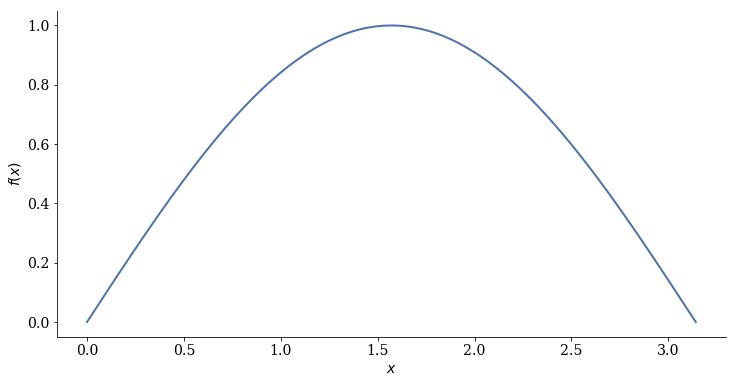

In [18]:
plt.plot(x,f(x))
plt.xlabel('$x$')
plt.ylabel('$f(x)$');

What we are really interested in is not the function itself, but its integral (weak forms!):

$$
    F = \int \limits_0^\pi \sin x\,\text{d}x = 2
$$

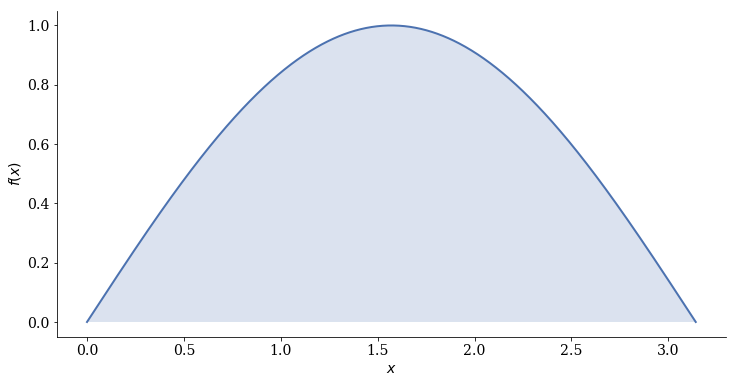

In [19]:
plt.plot(x,f(x))
plt.xlabel('$x$')
plt.ylabel('$f(x)$');
plt.fill_between(x,f(x),alpha=0.2);

Now assume the function above is only given at a set of discrete nodes.

In [20]:
n_nodes = 6
x_nodes = np.linspace(0,np.pi,n_nodes)
f_nodes = f(x_nodes)

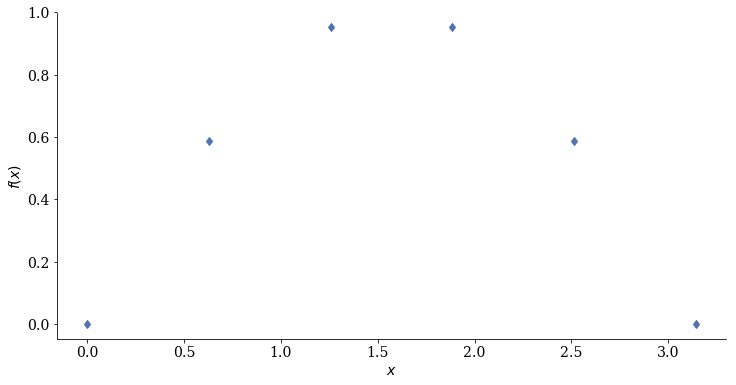

In [21]:
plt.plot(x_nodes,f_nodes,ls='',marker='d')
plt.xlabel('$x$')
plt.ylabel('$f(x)$');

How do we integrate the function now? We don't know what the function looks like in between the nodes. The idea is to create subdomains (finite elements) between each pair of adjacent nodes. In each element, the value is linearly interpolated between the two nodal values (i.e. they are connected by straight lines).

Thus we would have:

$$
    F = \int \limits_0^\pi \sin x\, \text{d}x = \sum \limits_{e=1}^{n_\text{elem}} \int \limits_{x_\text{left}}^{x_\text{right}} \sin x\, \text{d}x
$$

Let's try to create these elements:

In [22]:
for n in range(n_nodes-1):
    print("Element %i has nodes " %n, x_nodes[n:n+2])

Element 0 has nodes  [0.         0.62831853]
Element 1 has nodes  [0.62831853 1.25663706]
Element 2 has nodes  [1.25663706 1.88495559]
Element 3 has nodes  [1.88495559 2.51327412]
Element 4 has nodes  [2.51327412 3.14159265]


The integrals are evaluated numerically using so-called quadrature rules. To be general, these quadrature rules are defined not on specific intervals we need, i.e. $[x_\text{left},x_\text{right}]$, but on the interval $[-1,1]$:

$$
    \int \limits_{-1}^1 f(\xi)\,\text{d}\xi \approx \sum \limits_i^{n_\text{GP}} f(\xi_i) w_i
$$

So how to get from one to the other? We have to convert between both coordinate systems using the transformations $x(\xi)$ and $\xi(x)$:

$$
    F_e = \int \limits_{x_\text{left}}^{x_\text{right}} \sin x\, \text{d}x = \int \limits_{\xi(x_\text{left})=-1}^{\xi(x_\text{right})=1} \sin x(\xi) \, \frac{\partial x}{\partial \xi}\text{d}\xi
$$

The term $\partial x/\partial \xi$ is called Jacoban and simply scales the length of the the integration interval.

Since now, every element is only defined between $-1$ and $1$ we need to define the relationship between $x$ and $\xi$. This is done via shape functions:

$$
    N_\text{left} = \frac{1-\xi}{2} \qquad N_\text{right} = \frac{1 + \xi}{2}
$$

In [23]:
N_left = lambda xi: (1. - xi)/2.
N_right = lambda xi: (1. + xi)/2.

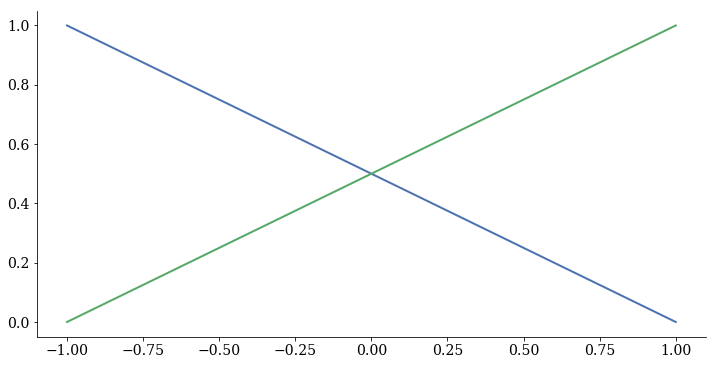

In [24]:
xi = np.linspace(-1,1,10)
plt.plot(xi,N_left(xi))
plt.plot(xi,N_right(xi));

We use these functions to linear interpolate both coordinates and function values based on their nodal values (isoparametric concept):

\begin{align*}
    x(\xi) &= N_\text{left}(\xi) x_\text{left} + N_\text{right}(\xi) x_\text{right}
    \\
    f(\xi) &= N_\text{left}(\xi) f_\text{left} + N_\text{right}(\xi) f_\text{right}
\end{align*}

In [25]:
interpolated_value = lambda xi, value_left, value_right: N_left(xi) * value_left + N_right(xi) * value_right

Now that we have an interpolation function, we can plot the values in the interval $-1$ to $1$ given the left and right nodal values of each element.

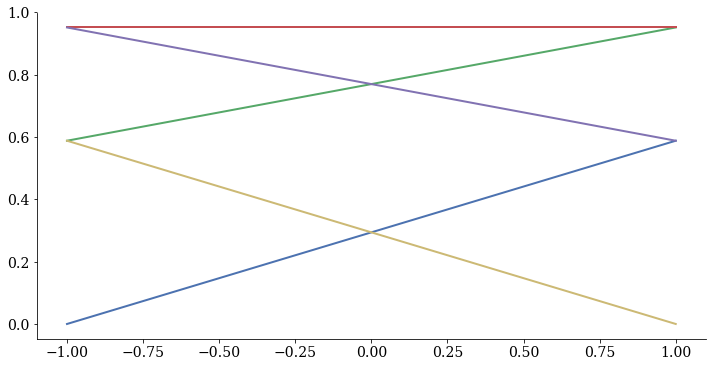

In [26]:
for n in range(n_nodes-1):
    plt.plot(xi,interpolated_value(xi,f_nodes[n],f_nodes[n+1]))

To plot things in the original coordinates, we simply use the interpolation function to also interpolate the nodal coordinates to coordinate values insight the elements.

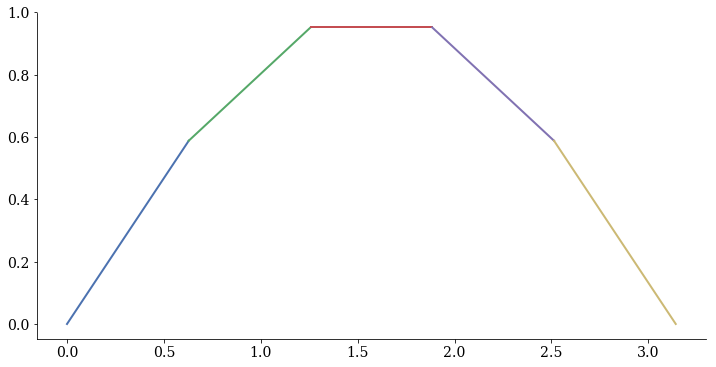

In [27]:
for n in range(n_nodes-1):
    plt.plot(interpolated_value(xi,x_nodes[n],x_nodes[n+1]),interpolated_value(xi,f_nodes[n],f_nodes[n+1]))

Now we have everything ready to integrate the function except for the Jacobian:

$$
    \frac{\partial x}{\partial \xi} = N'_\text{right}(\xi)x_\text{right} + N'_\text{left}(\xi)x_\text{left} = \frac{x_\text{right}}{2} - \frac{x_\text{left}}{2}
$$

which is the ratio of the element length in physical coordinates and the element length in natural coordinates.

Therefore, 

$$
    F_e = \int \limits_{-1}^{1} f(\xi) \frac{x_\text{right} - x_\text{left}}{2} \text{d}\xi 
$$

with 

$$
    f(\xi) = N_\text{left}(\xi) f_\text{left} + N_\text{right}(\xi) f_\text{right}
$$

Now we wish to perform the domain-wise integration. We use Gauß quadrature based on fixed locations in $[-1,1]$ and corresponding weights.

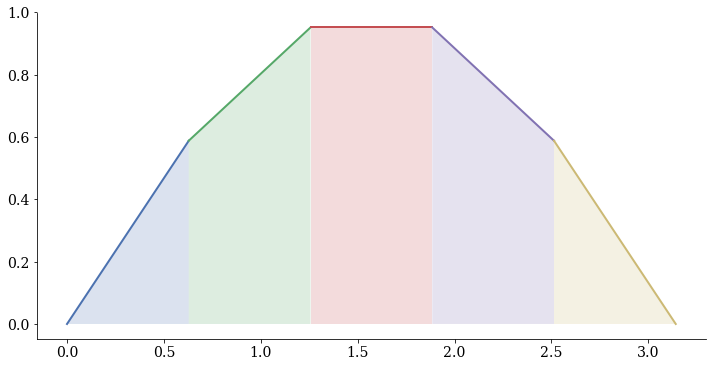

In [28]:
for n in range(n_nodes-1):
    plt.plot(interpolated_value(xi,x_nodes[n],x_nodes[n+1]),interpolated_value(xi,f_nodes[n],f_nodes[n+1]))
    plt.fill_between(interpolated_value(xi,x_nodes[n],x_nodes[n+1]),interpolated_value(xi,f_nodes[n],f_nodes[n+1]),alpha=0.2)

In [29]:
#variable to store integral
F = 0.
#locations of Gauß points and weights for Gauß points for a linear element (2 GP)
quad_points, quad_weights = np.polynomial.legendre.leggauss(2)
#loop over all elements
for n in range(n_nodes-1):
    #calculate dx/dxi
    Jacobian = (x_nodes[n+1] - x_nodes[n])/2.
    #sum over all Gauß points of f(xi_i) * w_i
    F_e = interpolated_value(quad_points[0],f_nodes[n],f_nodes[n+1]) * quad_weights[0]
    F_e += interpolated_value(quad_points[1],f_nodes[n],f_nodes[n+1]) * quad_weights[1]
    #scaling of integral to physical domain
    F_e *= Jacobian
    #add to global integral
    F += F_e
    

In [30]:
print("The numerical result is %.3f" %F)

The numerical result is 1.934
